# Modeling

In [189]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import product
from collections import defaultdict
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import sys
sys.path.append("../model")
from model import get_data
from pipeline import Pipeline
import constants as C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# taken from churn case study solution
def plot_feature_importances(df, feature_importances):
    feat_scores = pd.DataFrame({'Mean Decrease Impurity' : feature_importances},
                           index=C.FEATURES_TO_KEEP)
    feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
    feat_scores.plot(kind='barh', figsize=(8,8))

In [152]:
# stolen from sklearn's example
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ["Finished", "Cancelled"], rotation=45)
    plt.yticks(np.arange(2), ["Finished", "Cancelled"])
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Read data

In [187]:
engine = create_engine(C.ENGINE)
df = get_data(engine)
df["current_state"] = ((df["current_state"] != "finished") & (df["current_state"] != "started")).astype(int)
y = df.pop("current_state").values
X_train, X_test, y_train, y_test = train_test_split(df, y)

In [188]:
pipeline = Pipeline()
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [196]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy: {}".format(model.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7866990367844904
Precision: 0.8392359849860758
Recall: 0.5930354430921264


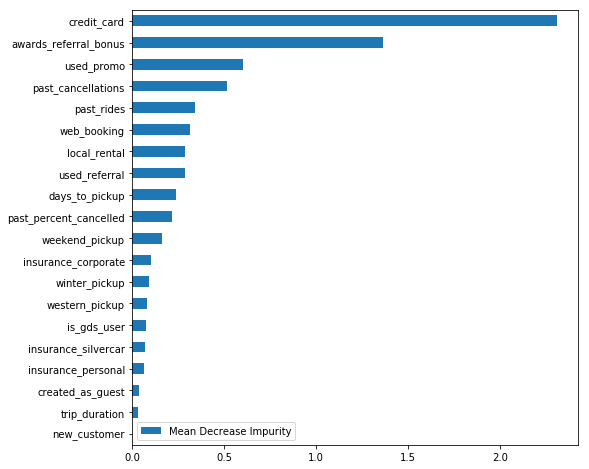

In [197]:
plot_feature_importances(X_train, np.abs(model.coef_[0]))

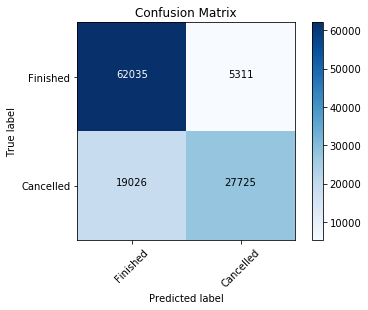

In [198]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [227]:
df.head()

,user_id,created_as_guest,local_rental,awards_referral_bonus,pickup,dropoff,created_at,promo_code_id,booking_application,reservation_frequency,time_zone,is_gds_user,referral_code,insurance_corporate,insurance_personal,insurance_silvercar,postal_code
0,12,0,0,0,41288.29167,41289.39583,41269.81361,NaN,None,None,cst,0.0,SJACOB,NaN,NaN,NaN,78701
1,49,0,0,0,41307.79167,41308.79167,41269.84853,NaN,None,None,cst,0.0,TDROID1,NaN,NaN,NaN,98103
2,51,0,0,0,41297.41667,41310.83333,41269.86818,NaN,None,None,cst,NaN,NaN,NaN,NaN,NaN,NaN
3,45,0,0,0,41291.54167,41293.83333,41269.91132,NaN,None,None,cst,0.0,QSILVER,NaN,NaN,NaN,None
4,55,0,0,0,41290.97917,41291.79167,41269.93505,NaN,None,New,cst,0.0,TSCOGGINS,NaN,NaN,NaN,78704


In [213]:
model = RandomForestClassifier(max_depth=8, n_estimators=50)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy: {}".format(model.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7885483404471634
Precision: 0.8855263606311556
Recall: 0.555795597955124


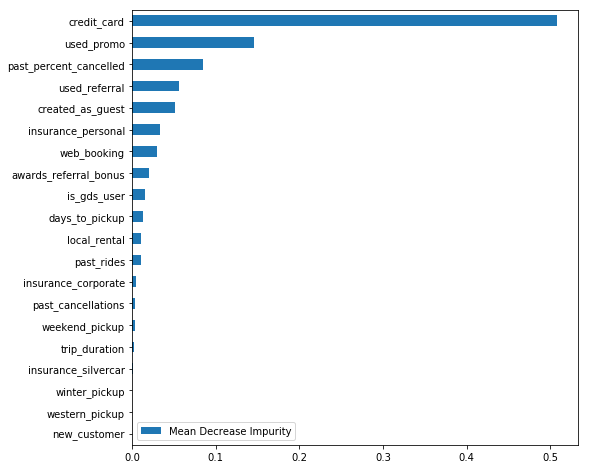

In [211]:
plot_feature_importances(df, model.feature_importances_)

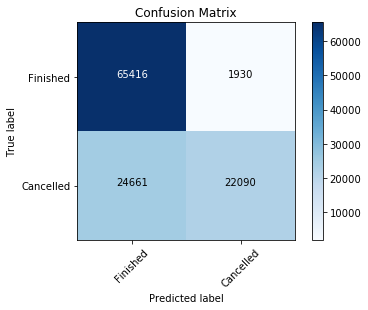

In [212]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [1097]:
gbc = GradientBoostingClassifier(n_estimators=20, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [1098]:
gbc.score(X_test, y_test)

0.90986262768580484

In [275]:
plot_feature_importances(df_model, gbc.feature_importances_)

In [274]:
predictions = gbc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)